# Mini project - CSLR on the German Phoenix dataset 

In [6]:
import pickle
import gzip
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# from wordcloud import WordCloud
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import re

import torch
from torch.optim.lr_scheduler import StepLR, MultiStepLR

import torch.nn as nn
import time
from skimage import io, transform

# import GPUtil

import tensorflow.compat.v1 as tf

# Lavenghtein distance (WER)
from jiwer import wer

import datetime as dt


In [8]:
import sys
sys.path.append('./san_code/') 

from bleu import compute_bleu
from rouge import rouge
from transformer_slr import make_model as TRANSFORMER
from utils import path_data, Batch, LabelSmoothing, NoamOpt
from viz import learning_curve_slr


In [9]:
if torch.cuda.is_available():
    print("Training on GPU!")
    device = torch.device("cuda:0")
else:
# Run on CPU
    print(
        "WARNING: Training on CPU, this will likely run out of memory, Go buy yourself a GPU!"
    )
    device = torch.device("cpu")


### Data Visualization

Storing data annotation in pandas dataframes for further analysis

In [3]:
with gzip.open("input/phoenix14t.pami0.train.annotations_only.gzip", "rb") as f:
    train_annotations = pd.DataFrame(pickle.load(f))
with gzip.open("input/phoenix14t.pami0.test.annotations_only.gzip", "rb") as f:
    test_annotations = pd.DataFrame(pickle.load(f))
with gzip.open("input/phoenix14t.pami0.dev.annotations_only.gzip", "rb") as f:
    dev_annotations = pd.DataFrame(pickle.load(f))


In [4]:
dev_annotations.head()


,name,signer,gloss,text
0,dev/11August_2010_Wednesday_tagesschau-2,Signer08,DRUCK TIEF KOMMEN,tiefer luftdruck bestimmt in den nächsten tage...
1,dev/11August_2010_Wednesday_tagesschau-3,Signer08,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...,das bedeutet viele wolken und immer wieder zum...
2,dev/11August_2010_Wednesday_tagesschau-8,Signer08,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...,meist weht nur ein schwacher wind aus untersch...
3,dev/25October_2010_Monday_tagesschau-22,Signer01,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...,am mittwoch hier und da nieselregen in der nor...
4,dev/05May_2011_Thursday_tagesschau-25,Signer08,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...,und nun die wettervorhersage für morgen freita...


In [5]:
test_annotations.head()


,name,signer,gloss,text
0,test/25October_2010_Monday_tagesschau-17,Signer01,REGEN SCHNEE REGION VERSCHWINDEN NORD REGEN KO...,regen und schnee lassen an den alpen in der na...
1,test/25October_2010_Monday_tagesschau-24,Signer01,DONNERSTAG NORDWEST REGEN REGION SONNE WOLKE W...,am donnerstag regen in der nordhälfte in der s...
2,test/15December_2010_Wednesday_tagesschau-37,Signer05,KRAEFTIG AB MORGEN FRUEH MEISTENS SCHNEE SCHNE...,vom nordmeer zieht ein kräftiges tief heran un...
3,test/10March_2011_Thursday_heute-58,Signer01,WOCHENENDE SONNE SAMSTAG SCHOEN TEMPERATUR BIS...,sonnig geht es auch ins wochenende samstag ein...
4,test/14August_2009_Friday_tagesschau-62,Signer05,DEUTSCH LAND MORGEN HOCH DRUCK KOMMEN WOLKE AU...,deutschland liegt morgen unter hochdruckeinflu...


In [6]:
train_annotations.head()


,name,signer,gloss,text
0,train/11August_2010_Wednesday_tagesschau-1,Signer08,JETZT WETTER MORGEN DONNERSTAG ZWOELF FEBRUAR,und nun die wettervorhersage für morgen donner...
1,train/11August_2010_Wednesday_tagesschau-4,Signer08,ORT REGEN DURCH REGEN KOENNEN UEBERSCHWEMMUNG ...,mancherorts regnet es auch länger und ergiebig...
2,train/11August_2010_Wednesday_tagesschau-5,Signer08,NORDWEST HEUTE NACHT TROCKEN BLEIBEN SUEDWEST ...,im nordwesten bleibt es heute nacht meist troc...
3,train/11August_2010_Wednesday_tagesschau-6,Signer08,TAGSUEBER OFT REGEN GEWITTER KOENNEN MANCHMAL ...,auch am tag gibt es verbreitet zum teil kräfti...
4,train/11August_2010_Wednesday_tagesschau-7,Signer08,WOLKE LOCH SPEZIELL NORDWEST,größere wolkenlücken finden sich vor allem im ...


Checking for missing values

In [7]:
total = train_annotations.isnull().sum().sort_values(ascending=False)
percent = (
    train_annotations.isnull().sum() / train_annotations.isnull().count()
).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
print(missing_data)

total = test_annotations.isnull().sum().sort_values(ascending=False)
percent = (
    test_annotations.isnull().sum() / test_annotations.isnull().count()
).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
print(missing_data)

total = dev_annotations.isnull().sum().sort_values(ascending=False)
percent = (
    dev_annotations.isnull().sum() / dev_annotations.isnull().count()
).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
print(missing_data)


        Total  Percent
name        0      0.0
signer      0      0.0
gloss       0      0.0
text        0      0.0
        Total  Percent
name        0      0.0
signer      0      0.0
gloss       0      0.0
text        0      0.0
        Total  Percent
name        0      0.0
signer      0      0.0
gloss       0      0.0
text        0      0.0


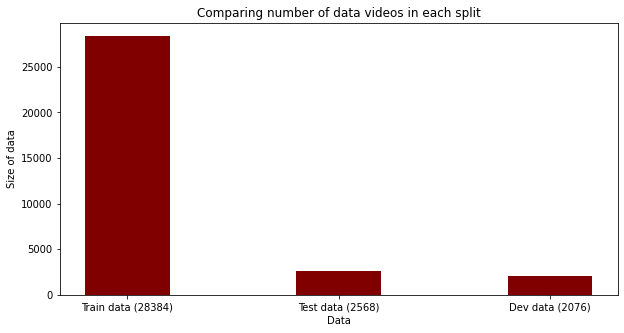

In [8]:
data = {
    f"Train data ({train_annotations.size})": train_annotations.size,
    f"Test data ({test_annotations.size})": test_annotations.size,
    f"Dev data ({dev_annotations.size})": dev_annotations.size,
}
fig = plt.figure(figsize=(10, 5))
plt.bar(list(data.keys()), list(data.values()), color="maroon", width=0.4)

plt.xlabel("Data")
plt.ylabel("Size of data")
plt.title("Comparing number of data videos in each split")

plt.show()


In [9]:
signer_data_total = OrderedDict()
signer_data_train = OrderedDict(
    sorted(dict(train_annotations["signer"].value_counts()).items())
)
signer_data_test = OrderedDict(
    sorted(dict(test_annotations["signer"].value_counts()).items())
)
signer_data_dev = OrderedDict(
    sorted(dict(dev_annotations["signer"].value_counts()).items())
)

for k, v in sorted(signer_data_train.items()):
    signer_data_total[k] = (
        signer_data_train[k] + signer_data_test[k] + signer_data_dev[k]
    )


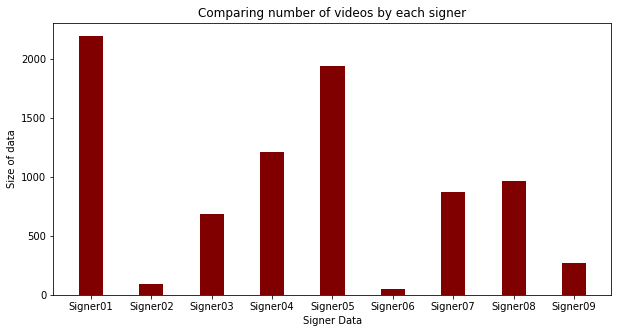

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    list(signer_data_total.keys()),
    list(signer_data_total.values()),
    color="maroon",
    width=0.4,
)

plt.xlabel("Signer Data")
plt.ylabel("Size of data")
plt.title("Comparing number of videos by each signer")
plt.show()


<BarContainer object of 9 artists>

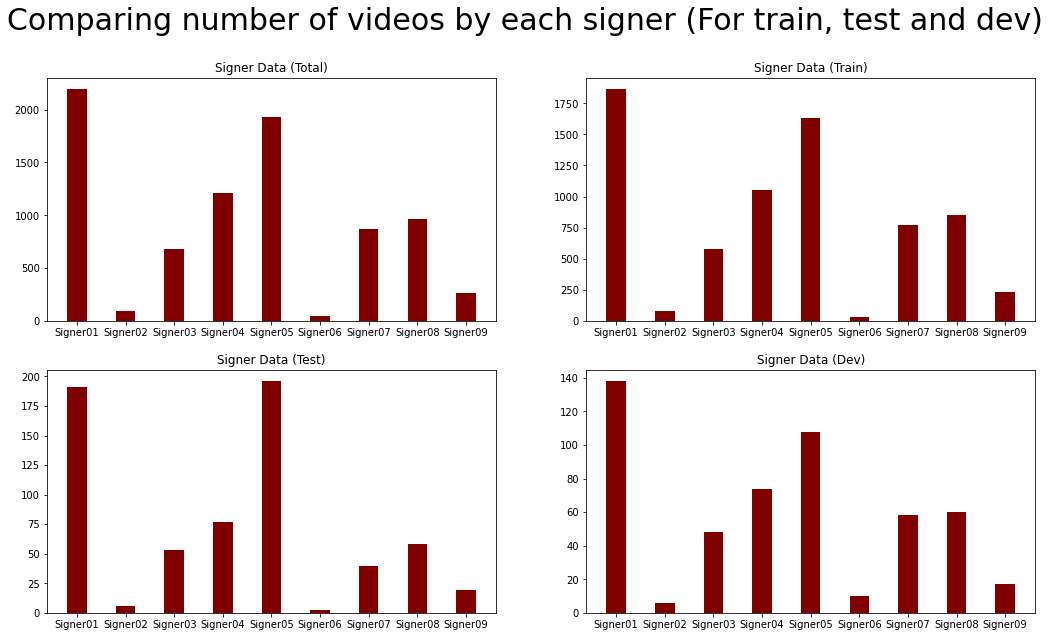

In [11]:
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]
figure, axis = plt.subplots(2, 2)
figure.suptitle(
    "Comparing number of videos by each signer (For train, test and dev)", size=30
)

axis[0, 0].set_title("Signer Data (Total)")
axis[0, 0].bar(
    list(signer_data_total.keys()),
    list(signer_data_total.values()),
    color="maroon",
    width=0.4,
)

axis[0, 1].set_title("Signer Data (Train)")
axis[0, 1].bar(
    list(signer_data_train.keys()),
    list(signer_data_train.values()),
    color="maroon",
    width=0.4,
)

axis[1, 0].set_title("Signer Data (Test)")
axis[1, 0].bar(
    list(signer_data_test.keys()),
    list(signer_data_test.values()),
    color="maroon",
    width=0.4,
)

axis[1, 1].set_title("Signer Data (Dev)")
axis[1, 1].bar(
    list(signer_data_dev.keys()),
    list(signer_data_dev.values()),
    color="maroon",
    width=0.4,
)


Visualizing the most common gloss

In [12]:
# gloss = " ".join(i for i in train_annotations.gloss)
# gloss = gloss + " ".join(i for i in test_annotations.gloss)
# gloss = gloss + " ".join(i for i in dev_annotations.gloss)

# plt.figure( figsize=(15,10))
# wordcloud = WordCloud(background_color="white").generate(gloss)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")/

# plt.show()


### Data Loading

In [13]:
train_annotations.shape


(7096, 4)

In [14]:
root_dir = "./videos_phoenix/images/"
video_dirs = [
    "./videos_phoenix/videos/train",
    "./videos_phoenix/videos/dev",
    "./videos_phoenix/videos/test",
]


In [15]:
length_data = []
for dire in video_dirs:
    for file in os.listdir(dire):
        filepath = os.path.join(dire, file)
        cap = cv2.VideoCapture(filepath)
        length_data.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))


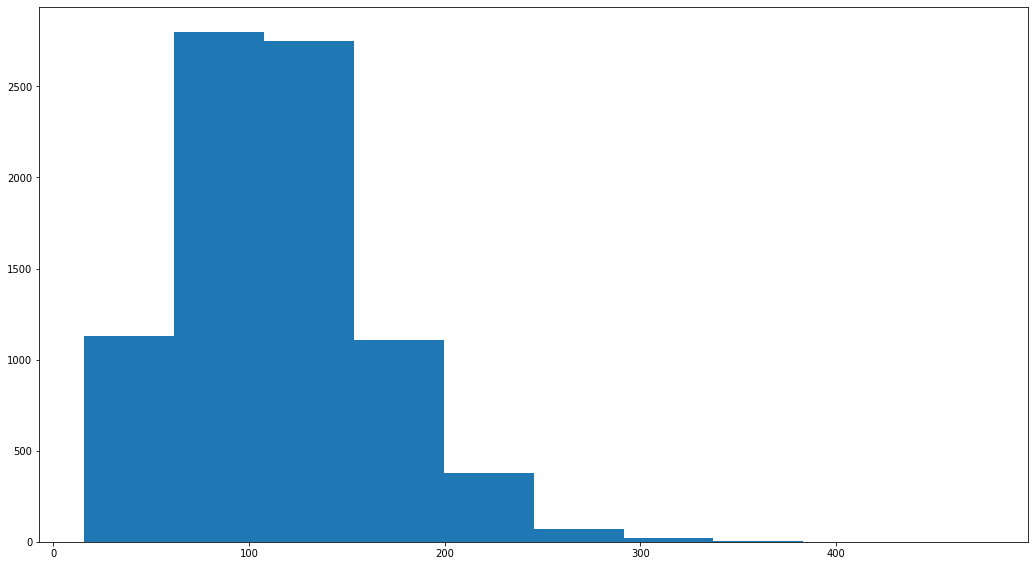

In [16]:
plt.hist(length_data)
length_threshold = 0.70 * max(length_data)
plt.show()


In [17]:
deleted_vids = 0
for dire in video_dirs:
    for file in os.listdir(dire):
        filepath = os.path.join(dire, file)
        cap = cv2.VideoCapture(filepath)
        if int(cap.get(cv2.CAP_PROP_FRAME_COUNT) > length_threshold):
            vid_name = filepath.replace("./videos_phoenix/videos/", "").replace(
                ".mp4", ""
            )
            deleted_vids += 1
            train_annotations.drop(
                train_annotations[train_annotations.name == vid_name].index,
                inplace=True,
            )
            test_annotations.drop(
                test_annotations[test_annotations.name == vid_name].index, inplace=True
            )
            dev_annotations.drop(
                dev_annotations[dev_annotations.name == vid_name].index, inplace=True
            )
deleted_vids


8

Subsetting the dataset

In [18]:
train_df = train_annotations.head(100)
test_df = test_annotations.head(10)
dev_df = dev_annotations.head(10)


In [19]:
train_df.to_csv("input/train_annotations.csv")
test_df.to_csv("input/test_annotations.csv")
dev_df.to_csv("input/dev_annotations.csv")


In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
# import keyframe_selecter as kf

# input_df = list(train_df["name"]) + list(test_df["name"]) + list(dev_df["name"])
# kf.write_images(input_df)


### Training the model

In [36]:
DATA = "./input/"
TRAIN_PATH = "./input/train_annotations.csv"
VALID_PATH = "./input/test_annotations.csv"
TEST_PATH = "./input/dev_annotations.csv"

ROOT_PATH = "./videos_phoenix/images/"
LOOKUP_TABLE = "./input/lookup_train.pickle"

DATA_TYPE = "keyfeatures"
FIXED_PADDING = None
RESCALE = 224
AUGMENTATION = True
NUM_WORKERS = 4
SHOW_SAMPLE = True
OPTIMIZER = "ADAM"
SCHEDULER = "multi-step"
MILESTONES = "10,30"
BATCH_SIZE = 2
CHANNELS = 3
INITIAL_LR = 0.0001
DISTRIBUTED = False
NUM_LAYERS = 2
HIDDEN_SIZE = 1280
N_HEADS = 10
DP_KEEP_PROB = 0.7
PRETRAINED = False
EMB_TYPE = "2d"
EMB_NETWORK = "mb2"
FULL_PRETRAINED = None
HAND_PRETRAINED = None
FREEZE_CNN = True
PARALLEL = False
HAND_QUERY = False
NUM_EPOCHS = 100
VALID_STEPS = 1
SAVE_STEPS = 10
DEBUG = False
CHECKPOINT = None
RESUME = True
LABEL_SMOOTHING = 0.1
REL_WINDOW = None
SAVE_DIR = "./output/EXPERIMENTATIONS"
ARCH = "CNN-attention-CTC"


In [23]:
def collate_fn(data, fixed_padding=None, pad_index=1232):
    """Creates mini-batch tensors w/ same length sequences by performing padding to the sequecenses.
    We should build a custom collate_fn to merge sequences w/ padding (not supported in default).
    Seqeuences are padded to the maximum length of mini-batch sequences (dynamic padding), else pad
    all Sequences to a fixed length.

    Returns:
        hand_seqs: torch tensor of shape (batch_size, padded_length).
        hand_lengths: list of length (batch_size);
        src_seqs: torch tensor of shape (batch_size, padded_length).
        src_lengths: list of length (batch_size);
        trg_seqs: torch tensor of shape (batch_size, padded_length).
        trg_lengths: list of length (batch_size);
    """

    def pad(sequences, t):
        lengths = [len(seq) for seq in sequences]

        # For sequence of images
        if t == "source":
            # Retrieve shape of single sequence
            # (seq_length, channels, n_h, n_w)
            seq_shape = sequences[0].shape
            if fixed_padding:
                padded_seqs = fixed_padding
                padded_seqs = torch.zeros(
                    len(sequences),
                    fixed_padding,
                    seq_shape[1],
                    seq_shape[2],
                    seq_shape[3],
                ).type_as(sequences[0])
            else:
                padded_seqs = torch.zeros(
                    len(sequences),
                    max(lengths),
                    seq_shape[1],
                    seq_shape[2],
                    seq_shape[3],
                ).type_as(sequences[0])

        # For sequence of words
        elif t == "target":
            padded_seqs = np.full(
                (len(sequences), max(lengths)), fill_value=pad_index, dtype=int
            )

        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]

        return padded_seqs, lengths

    src_seqs = []
    trg_seqs = []

    for element in data:
        src_seqs.append(element["images"])
        trg_seqs.append(element["translation"])

    # pad sequences
    src_seqs, src_lengths = pad(src_seqs, "source")
    trg_seqs, trg_lengths = pad(trg_seqs, "target")

    return src_seqs, src_lengths, trg_seqs, trg_lengths, None, None


def show_batch(sample_batched):
    """Show sequence of images with translation for a batch of samples."""

    images_batch, images_length, trans_batch, trans_length, _, _ = sample_batched
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    # #Show only one sequence of the batch
    # print(images_batch[0:0])
    # print(images_length[0])
    # print(trans_batch)
    grid = utils.make_grid(images_batch[0, : images_length[0]])
    grid = grid.numpy()
    return np.transpose(grid, (1, 2, 0))


In [24]:
class PhoenixDataset(Dataset):
    """Sequential Sign language images dataset."""

    def __init__(
        self,
        csv_file,
        root_dir,
        lookup_table,
        transform=None,
        rescale=224,
        sos_index=1,
        eos_index=2,
        unk_index=0,
        fixed_padding=None,
        hand_dir=None,
        hand_transform=None,
        channels=3,
    ):
        # Get data
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.hand_dir = hand_dir

        self.transform = transform
        self.hand_transform = hand_transform

        self.rescale = rescale

        self.channels = channels

        # index used for eos token and unk
        self.eos_index = eos_index
        self.unk_index = unk_index
        self.sos_index = sos_index

        # Retrieve lookup table dic from path
        with open(lookup_table, "rb") as pickle_file:
            self.lookup_table = pickle.load(pickle_file)

    def __len__(self):
        # Return size of dataset
        return len(self.annotations)

    def __getitem__(self, idx):
        # Retrieve the name id of sequence from csv annotations
        name = self.annotations.iloc[idx, 1].split("|")[0]
        seq_name = os.path.join(self.root_dir, name)
        for path, d, files in os.walk(seq_name):
            seq_length = len(files)
            trsf_images = torch.zeros(
                (seq_length, self.channels, self.rescale, self.rescale)
            )

            # Save the images of seq
            # for i in range(1, seq_length):
            i = 1
            for file in files:
                img_name = os.path.join(path, file)

                # NOTE: some images got shape of (260, 220, 4)
                if io.imread(img_name).shape[2] == self.channels:
                    trsf_images[i - 1] = self.transform(
                        io.imread(img_name, plugin="pil")
                    )
                else:
                    trsf_images[i - 1] = self.transform(
                        io.imread(img_name, plugin="pil")[:, :, : self.channels]
                    )
                i += 1

        # Retrive the translation (ground truth text translation) from csv annotations
        translation = self.annotations.iloc[idx, -1].split("|")[-1]
        # Split translation phrase to set of words
        translation = translation.split(" ")
        # Save index values of the words
        trans = []
        # Add current words in lookup table
        for word in translation:
            # Get index of the current word if it exists in dict
            if word in self.lookup_table.keys():
                trans.append(self.lookup_table[word])
            else:
                # If words doesnt exist in train vocab then <unk>
                trans.append(self.unk_index)
        # NOTE: full frame seq and hand seq should be with the same seq length
        sample = {
            "images": trsf_images,
            "right_hands": None,
            "translation": trans,
        }
        return sample


In [25]:
transformed_dataset = PhoenixDataset(
    csv_file="./input/train_annotations.csv",
    root_dir="./input/",
    lookup_table="./input/lookup_train.pickle",
)


In [26]:
def loader(
    csv_file,
    root_dir,
    lookup,
    rescale,
    augmentation,
    batch_size,
    num_workers,
    show_sample,
    istrain=False,
    mean_path="FulFrame_Mean_Image_227x227.npy",
    fixed_padding=None,
    data_stats=None,
    channels=3,
):
    if augmentation and istrain:

        if data_stats:
            trans = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomAffine(10),
                    transforms.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
                    ),
                    transforms.Resize((rescale, rescale)),
                    transforms.ToTensor(),
                    # Imagenet std and mean
                    transforms.Normalize(
                        mean=data_stats["mean"], std=data_stats["std"]
                    ),
                ]
            )
        else:
            trans = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomAffine(10),
                    transforms.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
                    ),
                    transforms.Resize((rescale, rescale)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            )

    else:

        if data_stats:
            trans = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.Resize((rescale, rescale)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=data_stats["mean"], std=data_stats["std"]
                    ),
                ]
            )

        else:
            trans = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.Resize((rescale, rescale)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            )

    ##Iterate through the dataset and apply data transformation on the fly

    # Apply data augmentation to avoid overfitting
    transformed_dataset = PhoenixDataset(
        csv_file=csv_file,
        root_dir=root_dir,
        lookup_table=lookup,
        transform=trans,
        rescale=rescale,
        hand_dir=None,
        hand_transform=None,
        channels=channels,
    )

    size = len(transformed_dataset)

    # Iterate in batches
    # Note: put num of workers to 0 to avoid memory saturation
    dataloader = DataLoader(
        transformed_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    # Show a sample of the dataset
    if show_sample and istrain:
        for i_batch, sample_batched in enumerate(dataloader):
            # plt.figure()
            img = show_batch(sample_batched)
            # print(img)
            plt.axis("off")
            plt.ioff()
            plt.imshow(img)
            # plt.show()
            # plt.savefig('data_sample.png')
            break

    return dataloader, size


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


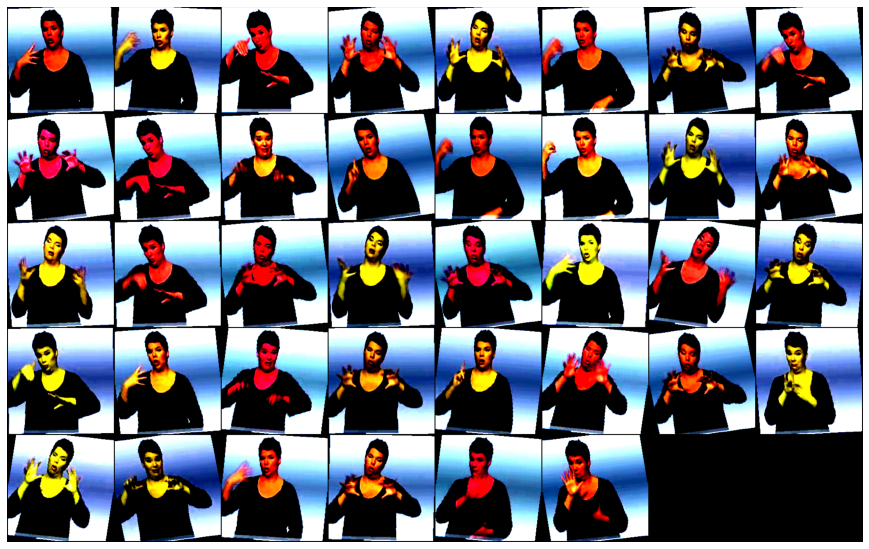

In [27]:
train_dataloader, train_size = loader(
    csv_file=TRAIN_PATH,
    root_dir=ROOT_PATH,
    lookup=LOOKUP_TABLE,
    rescale=RESCALE,
    augmentation=AUGMENTATION,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    show_sample=SHOW_SAMPLE,
    istrain=True,
    fixed_padding=FIXED_PADDING,
    data_stats=None,
    channels=CHANNELS,
)

# No data augmentation for valid data
valid_dataloader, valid_size = loader(
    csv_file=VALID_PATH,
    root_dir=ROOT_PATH,
    lookup=LOOKUP_TABLE,
    rescale=RESCALE,
    augmentation=AUGMENTATION,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    show_sample=SHOW_SAMPLE,
    istrain=False,
    fixed_padding=FIXED_PADDING,
    data_stats=None,
    channels=CHANNELS,
)


In [28]:
print("Dataset sizes:")
dataset_sizes = {}
dataset_sizes.update({"train": train_size})
dataset_sizes.update({"valid": valid_size})
print(dataset_sizes)

# Retrieve size of target vocab
with open(LOOKUP_TABLE, "rb") as pickle_file:
    vocab = pickle.load(pickle_file)

vocab_size = len(vocab)

# Switch keys and values of vocab to easily look for words
vocab = {y: x for x, y in vocab.items()}

# You should find
print("vocabulary size:" + str(vocab_size))


Dataset sizes:
{'train': 100, 'valid': 10}
vocabulary size:2891


In [29]:
def run_epoch(model, data, is_train=False, device="cuda:0", n_devices=1):

    if is_train:
        model.train()  # Set model to training mode
        print("Training..")
        phase = "train"
    else:
        model.eval()  # Set model to evaluate mode
        print("Evaluating..")
        phase = "valid"

    start_time = time.time()

    loss = 0.0
    total_loss = 0.0
    total_tokens = 0
    batch_tokens = 0.0
    total_seqs = 0
    tokens = 0
    total_correct = 0.0
    n_correct = 0.0

    wer_score = 0.0
    total_wer_score = 0.0
    count = 0

    gt = []
    hyp = []

    # For progress bar
    # bar = progressbar.ProgressBar(
    #     maxval=dataset_sizes[phase],
    #     widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.Percentage()],
    # )
    # bar.start()
    j = 0
    # Loop over minibatches
    for step, (x, x_lengths, y, y_lengths, hand_regions, hand_lengths) in enumerate(
        data
    ):

        # Update progress bar with every iter
        j += len(x)
        # bar.update(j)

        y = torch.from_numpy(y).to(device)
        x = x.to(device)

        if HAND_QUERY:
            hand_regions = hand_regions.to(device)
        else:
            hand_regions = None

        # NOTE: clone y to avoid overridding it
        batch = Batch(
            x_lengths,
            y_lengths,
            hand_lengths,
            trg=None,
            emb_type=EMB_TYPE,
            
            DEVICE=device,
            fixed_padding=FIXED_PADDING,
            rel_window=REL_WINDOW,
        )

        if DISTRIBUTED:

            # Zeroing gradients
            feature_extractor.zero_grad()
            encoder.zero_grad()
            position.zero_grad()
            output_layer.zero_grad()

            src_emb, _, _ = feature_extractor(x)
            src_emb = position(src_emb)
            src_emb = encoder(src_emb, None, batch.src_mask)
            output_context = output_layer(src_emb)

            if HAND_QUERY:
                hand_extractor.zero_grad()

                hand_emb = hand_extractor(hand_regions)
                hand_emb = position(hand_emb)
                hand_emb = encoder(hand_emb, None, batch.src_mask)
                output_hand = output_layer(hand_emb)

                comb_emb = encoder(src_emb, hand_emb, batch.rel_mask)
                output = output_layer(comb_emb)

            else:
                output = None
                output_hand = None

        else:
            # Zeroing gradients
            model.zero_grad()

            # Shape(batch_size, tgt_seq_length, tgt_vocab_size)
            # NOTE: no need for trg if we dont have a decoder
            output, output_context, output_hand = model.forward(
                x, batch.src_mask, batch.rel_mask, hand_regions, ARCH
            )

        # CTC loss expects (Seq, batch, vocab)
        if HAND_QUERY:
            output = output.transpose(0, 1)
            output_context = output_context.transpose(0, 1)
            output_hand = output_hand.transpose(0, 1)
        else:
            output = output_context.transpose(0, 1)

        x_lengths = torch.IntTensor(x_lengths)
        y_lengths = torch.IntTensor(y_lengths)

        if is_train == False:

            # Run CTC beam decoder using tensorflow
            # NOTE: blank token in Tensorflow must be  (N-classes - 1)

            # Return tuple of sentences and probs
            decodes, _ = tf.nn.ctc_beam_search_decoder(
                inputs=output.cpu().detach().numpy(),
                sequence_length=x_lengths.cpu().detach().numpy(),
                merge_repeated=False,
                beam_width=10,
                top_paths=1,
            )
            # Get top 1 path
            # (batch, Seq)
            pred = decodes[0]

            # Transform sparse tensor to numpy
            pred = tf.sparse.to_dense(pred).numpy()

            for i in range(len(y)):

                # NOTE: we are doing log inside ctcdecoder
                # pred = (seq, beam, batch)

                ys = y[i, : y_lengths[i]]
                p = pred[i]

                hyp = " ".join([vocab[x.item()] for x in p])
                gt = " ".join([vocab[x.item()] for x in ys])
                # print("=================================")
                # print(total_wer_score)
                # print(count)
                # print("=================================")

                total_wer_score += wer(gt, hyp, standardize=True)
                count += 1

        # output (Seq, batch, vocab_size)
        # y (batch, trg_size)
        # x_lengths (batch)
        # y_lengths (batch)

        # NOTE: produce Nan values if x length > y lengths
        # When extracting keyframes, make sure your src lengths are long enough or simply use zero infinity
        # Doing average loss here

        # IMPORTANT: Use Pytorch CTCloss
        # print(output.shape)
        # print(y.shape)
        loss = ctc_loss(output, y.cpu(), x_lengths.cpu(), y_lengths.cpu())

        if HAND_QUERY:
            loss += ctc_loss(output_context, y.cpu(), x_lengths.cpu(), y_lengths.cpu())
            loss += ctc_loss(output_hand, y.cpu(), x_lengths.cpu(), y_lengths.cpu())
            loss = loss / 3

        total_loss += loss
        total_seqs += batch.seq
        total_tokens += (y != blank_index).data.sum()
        tokens += (y != blank_index).data.sum()
        batch_tokens += (y != blank_index).data.sum()

        if is_train:

            loss.backward()

            # Weight clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

            if step % 100 == 0:
                elapsed = time.time() - start_time
                print(
                    "Step: %d, Loss: %f, Frame per Sec: %f, Token per sec: %f"
                    % (
                        step,
                        (loss / batch_tokens),
                        total_seqs * BATCH_SIZE / elapsed,
                        tokens / elapsed,
                    )
                )

                start_time = time.time()
                total_seqs = 0
                tokens = 0

        batch_tokens = 0.0

        # Free some memory
        # NOTE: this helps alot in avoiding cuda out of memory
        del loss, output, output_context, output_hand, y, hand_regions, batch

    if is_train:
        print("Average Loss: %f" % (total_loss.item() / total_tokens.item()))
        return total_loss.item() / total_tokens.item()

    else:
        # Measure WER of all dataset
        print("Measuring WER..")
        print("Average WER: %f" % (total_wer_score / count))

        return total_loss.item() / total_tokens.item(), total_wer_score / count


In [30]:
model = TRANSFORMER(
    tgt_vocab=vocab_size,
    n_stacks=NUM_LAYERS,
    n_units=HIDDEN_SIZE,
    n_heads=N_HEADS,
    d_ff=2048,
    dropout=1.0 - DP_KEEP_PROB,
    image_size=RESCALE,
    pretrained=PRETRAINED,
    emb_type=EMB_TYPE,
    emb_network=EMB_NETWORK,
    full_pretrained=FULL_PRETRAINED,
    hand_pretrained=HAND_PRETRAINED,
    freeze_cnn=FREEZE_CNN,
    channels=CHANNELS,
)

# Load model on GPU or multiple GPUs
if torch.cuda.device_count() > 1 and PARALLEL:
    # How many GPUs you are using
    n_devices = torch.cuda.device_count()

    if DISTRIBUTED:
        # Split GPUs for both feature extraction and sequence learning (Transformer)
        n_devices_split = int(n_devices / 2)
        print(
            "Using ",
            n_devices_split,
            "GPUs for feature extraction and ",
            n_devices - n_devices_split,
            "GPUs for sequence learning.",
        )

        devices = list(range(0, n_devices_split))
        feature_extractor = nn.DataParallel(model.src_emb, device_ids=devices).to(
            device
        )

        if HAND_QUERY:
            hand_extractor = nn.DataParallel(model.hand_emb, device_ids=devices).to(
                device
            )

        devices = list(range(n_devices_split, n_devices))

        encoder = nn.DataParallel(model.encoder, device_ids=devices).to(n_devices_split)
        position = nn.DataParallel(model.position, device_ids=devices).to(
            n_devices_split
        )
        output_layer = nn.DataParallel(model.output_layer, device_ids=devices).to(
            n_devices_split
        )

    else:
        print("Using ", n_devices, "GPUs!, Let's GO!")
        model = nn.DataParallel(model).to(device)
else:
    print("Training using 1 device (GPU/CPU), use very small batch_size!")
    # Load model into device (GPU OR CPU)
    n_devices = 1
    model = model.to(device)

    if DISTRIBUTED:
        print("Can't use distributed training since you have a single GPU!")
        quit(0)


# print("Loading to GPUs")
# print(GPUtil.showUtilization())

train_ppls = []
train_losses = []
val_ppls = []
val_losses = []
ns_words = []
bleu_1s = []
bleu_2s = []
bleu_3s = []
bleu_4s = []

best_val_so_far = np.inf
best_bleu = 0.0
best_err_so_far = 999.9
times = []

if OPTIMIZER == "ADAM":
    optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)

elif OPTIMIZER == "noam":
    optimizer = NoamOpt(
        HIDDEN_SIZE,
        1,
        400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9),
    )


# In debug mode, only run one epoch
if DEBUG:
    num_epochs = 1
else:
    num_epochs = NUM_EPOCHS

# Load weights from previous training session
# Resume training or start from start w/ pretrained weights
if CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint["model_state_dict"])

    if RESUME:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        loss_fn = checkpoint["loss"]
        best_bleu = checkpoint["best_wer"]

if CHECKPOINT == None or RESUME == False:
    start_epoch = 0

    if SCHEDULER == "multi-step":
        milestones = [int(v.strip()) for v in MILESTONES.split(",")]
        scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    elif SCHEDULER == "stepLR":
        milestones = [int(v.strip()) for v in MILESTONES.split(",")]
        scheduler = StepLR(optimizer, step_size=MILESTONES, gamma=0.1)
    else:
        print("No scheduler!")

    if LABEL_SMOOTHING:
        loss_fn = LabelSmoothing(
            size=len(vocab), padding_idx=0, smoothing=LABEL_SMOOTHING
        )
    else:
        loss_fn = nn.NLLLoss(ignore_index=0, reduction="sum")

blank_index = len(vocab) - 1

# zero_infinity to avoid having numerical instabilities
# NOTE: N-class - 1 is for BLANK token if we are using tensorflow decoder
ctc_loss = nn.CTCLoss(blank=blank_index, reduction="sum", zero_infinity=True)


###
# Main Training loop

for epoch in range(start_epoch, num_epochs):

    start = time.time()

    print("\nEPOCH " + str(epoch) + " ------------------")

    # RUN MODEL ON TRAINING DATA
    train_loss = run_epoch(model, train_dataloader, True, device=device)
    print("After train epoch..")
    # print(GPUtil.showUtilization())

    # Save perplexity
    train_ppl = np.exp(train_loss)

    if SCHEDULER:
        scheduler.step()

    if epoch % VALID_STEPS == 0:

        # Use it for evaluation with blue
        translation_corpus = []
        reference_corpus = []

        # RUN MODEL ON VALIDATION DATA
        # NOTE: Helps with avoiding memory saturation
        with torch.no_grad():
            val_loss, word_err = run_epoch(model, valid_dataloader)

            if word_err < best_err_so_far:
                best_err_so_far = word_err

                # if args.save_best:
                print("Saving entire model with best params")
                torch.save(model, os.path.join(SAVE_DIR, "best_params.pt"))

                print("Saving full-frame (CNN) with best params")
                torch.save(
                    model.src_emb.state_dict(),
                    os.path.join(SAVE_DIR, "full_cnn_best_params.pt"),
                )

                if HAND_QUERY:
                    print("Saving hand regions (CNN) with best params")
                    torch.save(
                        model.hand_emb.state_dict(),
                        os.path.join(SAVE_DIR, "hand_cnn_best_params.pt"),
                    )

        val_ppl = np.exp(val_loss)

        # SAVE RESULTS
        train_ppls.append(train_ppl)
        val_ppls.append(val_ppl)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        times.append(time.time() - start)
        ns_words.append(word_err)

        log_str = (
            "epoch: "
            + str(epoch)
            + "\t"
            + "train ppl: "
            + str(train_ppl)
            + "\t"
            + "val ppl: "
            + str(val_ppl)
            + "\t"
            + "train loss: "
            + str(train_loss)
            + "\t"
            + "val loss: "
            + str(val_loss)
            + "\t"
            + "WER: "
            + str(word_err)
            + "\t"
            + "BEST WER: "
            + str(best_err_so_far)
            + "\t"
            + "time (s) spent in epoch: "
            + str(times[-1])
        )

        print(log_str)

        with open(os.path.join(SAVE_DIR, "log.txt"), "a") as f_:
            f_.write(log_str + "\n")

        # SAVE LEARNING CURVES
        lc_path = os.path.join(SAVE_DIR, "learning_curves.npy")
        print("\nDONE\n\nSaving learning curves to " + lc_path)
        np.save(
            lc_path,
            {
                "train_ppls": train_ppls,
                "val_ppls": val_ppls,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "wer": ns_words,
            },
        )

        print("Saving plots")
        # learning_curve_slr(SAVE_DIR)

        # Save every model every 10 epoch
        if epoch % SAVE_STEPS == 0:
            # Save after each epoch and save optimizer state
            print("Saving model parameters for epoch: " + str(epoch))
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss_fn,
                    "best_wer": best_err_so_far,
                },
                os.path.join(
                    SAVE_DIR,
                    "epoch_" + str(epoch) + "_wer_" + str(word_err) + ".pt",
                ),
            )

        # We reached convergence
        if train_ppl <= 1:
            print("Yay!!")
            break


False
False
Training using 1 device (GPU/CPU), use very small batch_size!

EPOCH 0 ------------------
Training..


/home/codevardhan/fyp/mini-project/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Step: 0, Loss: 26.386536, Frame per Sec: 89.278155, Token per sec: 19.839590
Average Loss: 2.776115
After train epoch..
Evaluating..


2022-07-27 14:18:19.182640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:18:19.182999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/codevardhan/fyp/mini-project/env/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-27 14:18:19.183155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/codevardhan/fyp/mini-project/env/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-27 14:18:19.183244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

Measuring WER..
Average WER: 1.000000
Saving entire model with best params
Saving full-frame (CNN) with best params
epoch: 0	train ppl: 16.05651678103181	val ppl: 7.545939279649497	train loss: 2.7761147971389915	val loss: 2.021009574816065	WER: 1.0	BEST WER: 1.0	time (s) spent in epoch: 16.840455055236816

DONE

Saving learning curves to ./output/EXPERIMENTATIONS/learning_curves.npy
Saving plots
Saving model parameters for epoch: 0

EPOCH 1 ------------------
Training..
Step: 0, Loss: 3.069892, Frame per Sec: 91.314502, Token per sec: 26.089857
Average Loss: 1.825229
After train epoch..
Evaluating..
Measuring WER..
Average WER: 1.000000
epoch: 1	train ppl: 6.204213530584016	val ppl: 8.812906593041783	train loss: 1.8252286629334784	val loss: 2.1762173052915594	WER: 1.0	BEST WER: 1.0	time (s) spent in epoch: 15.62012767791748

DONE

Saving learning curves to ./output/EXPERIMENTATIONS/learning_curves.npy
Saving plots

EPOCH 2 ------------------
Training..
Step: 0, Loss: 2.935925, Frame pe

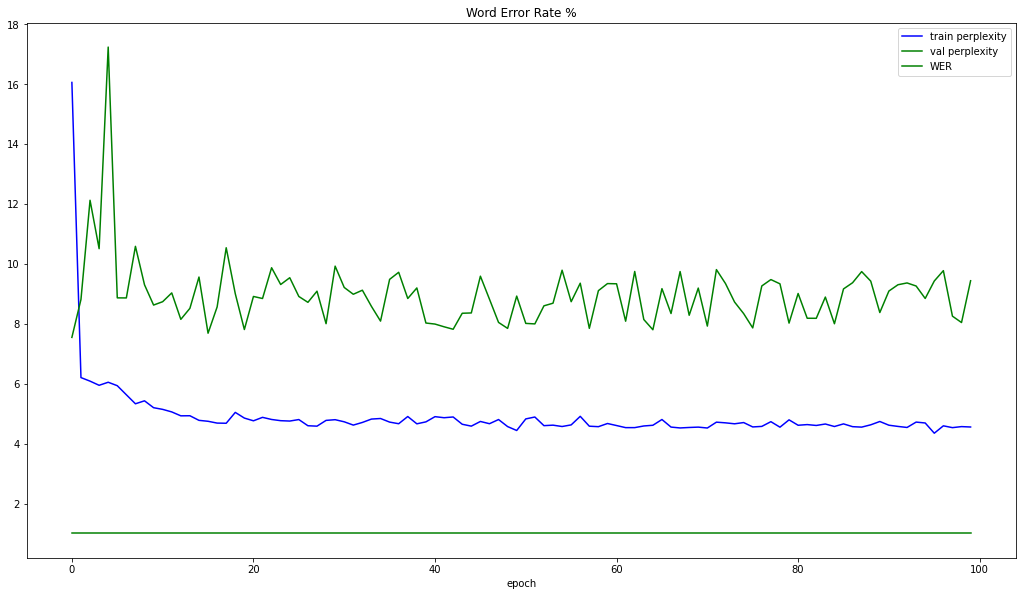

In [31]:
learning_curve_slr(SAVE_DIR)

In [67]:
SEED=1111
SAVE=True
DATA_STATS=None
HAND_STATS=None
IMAGE_TYPE='rgb'
TXT=None
MODEL_PATH="./output/EXPERIMENTATIONS/best_params.pt"
HEATMAP=False
ROUGE=True
BLEU=False

In [68]:
start_date = dt.datetime.now().strftime("%Y-%m-%d-%H.%M")
print ("Start Time: "+start_date)

#Set the random seed manually for reproducibility.
torch.manual_seed(SEED)

#experiment_path = PureWindowsPath('EXPERIMENTATIONS\\' + start_date)
save_path = os.path.join('output', 'EVALUATION', start_date)

# Creates an experimental directory and dumps all the args to a text file
if(SAVE):
    if(os.path.exists(save_path)):
        print('Evaluation already exists..')
    else:
        os.makedirs(save_path)

    print ("\nPutting log in EVALUATION/%s"%start_date)

    #Dump all configurations/hyperparameters in txt
    with open (os.path.join(save_path,'eval_config.txt'), 'w') as f:
        f.write('Experimentation done at: '+ str(start_date)+' with current configurations:\n')


Start Time: 2022-07-27-20.58

Putting log in EVALUATION/2022-07-27-20.58


In [72]:
# train_path, valid_path, test_path = path_data(data_path=DATA, task='SLR', hand_query=args.hand_query)

if (IMAGE_TYPE == 'rgb'):
    channels = 3
elif(IMAGE_TYPE == 'grayscale'):
    channels = 1
else:
    print('Image type is not supported!')
    quit(0)

#No data augmentation for test data
test_dataloader, test_size = loader(csv_file=TEST_PATH,
                root_dir=ROOT_PATH,
                lookup=LOOKUP_TABLE,
                rescale = RESCALE,
                augmentation = None,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS,
                show_sample = SHOW_SAMPLE,
                istrain=False,
                data_stats=DATA_STATS,
                channels=channels
                )

#No data augmentation for test data
valid_dataloader, valid_size = loader(csv_file=VALID_PATH,
                root_dir=ROOT_PATH,
                lookup=LOOKUP_TABLE,
                rescale = RESCALE,
                augmentation = None,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS,
                show_sample = SHOW_SAMPLE,
                istrain=False,
                data_stats=DATA_STATS,
                channels=channels
                )

print('Test dataset size: '+str(test_size))
print('Valid dataset size: '+str(valid_size))

#Retrieve size of target vocab
with open(LOOKUP_TABLE, 'rb') as pickle_file:
   vocab = pickle.load(pickle_file)

vocab_size = len(vocab)

#Switch keys and values of vocab to easily look for words
vocab = {y:x for x,y in vocab.items()}

print('vocabulary size:' + str(vocab_size))

#Loop through test and val sets
dataloaders = [valid_dataloader, test_dataloader]
sizes = [valid_size, test_size]
dataset = ['valid', 'test']

#Blank token index
blank_index = 1232

#-------------------------------------------------------------------------------


#Run evaluation from txt files
if(TXT):
    for d in range(len(dataset)):

        print(dataset[d])

        #Hypotheses file
        with open(os.path.join(TXT,'simpl_translations_'+dataset[d]+'.txt')) as f:
            hyp = f.read().splitlines()

        #Reference file
        with open(os.path.join(TXT,'simpl_references_'+dataset[d]+'.txt')) as f:
            ref = f.read().splitlines()

        assert len(hyp) == len(ref)

        total_wer_score = 0.0
        count = 0
        #Measuring WER
        for i in range(len(ref)):
            total_wer_score += wer(ref[i], hyp[i], standardize=True)
            count += 1

        print(total_wer_score/count)

    quit(0)


#-------------------------------------------------------------------------------


#Run on GPU
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
#Run on CPU
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")


#-------------------------------------------------------------------------------


#Load the whole model with state dict
model = TRANSFORMER(tgt_vocab=vocab_size, n_stacks=2, n_units=1280,
                            n_heads=10, d_ff=2048, dropout=0.3, image_size=224,
                                                       emb_type='2d', emb_network='mb2')
# model.load_state_dict(torch.load(MODEL_PATH)['state_dict'])

#Load entire model w/ weights
model = torch.load(MODEL_PATH, map_location=device)

model = model.to(device)
print("Model successfully loaded")

model.eval()   # Set model to evaluate mode
print ("Evaluating..")

start_time = time.time()


for d in range(len(sizes)):

    dataloader = dataloaders[d]
    size = sizes[d]
    print(dataset[d])

    #For progress bar
    # bar = progressbar.ProgressBar(maxval=size, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # bar.start()
    i = 0
    count = 0

    #Save translation and reference sentences
    translation_corpus = []
    reference_corpus = []

    total_wer_score = 0.0
    count = 0

    #Loop over minibatches
    # for step, (x, x_lengths, y, y_lengths, hand_regions, hand_lengths, name) in enumerate(dataloader):
    for step, (x, x_lengths, y, y_lengths, hand_regions, name) in enumerate(dataloader):
    
    # for step, (x, x_lengths, y, y_lengths, name) in enumerate(dataloader):

        #Update progress bar with every iter
        i += len(x)
        # bar.update(i)

        if(HAND_QUERY):
             hand_regions = hand_regions.to(device)
        else:
             hand_regions = None

        y = torch.from_numpy(y).to(device)
        x = x.to(device)

        batch = Batch(x_lengths, y_lengths, hand_lengths=None, trg=None, DEVICE=device, emb_type=EMB_TYPE, fixed_padding=None, rel_window=REL_WINDOW)
        # batch = Batch(x_lengths, y_lengths, trg=None, DEVICE=device, emb_type=EMB_TYPE, fixed_padding=None, rel_window=REL_WINDOW)

        #with torch.no_grad():

        output, output_context, output_hand = model.forward(x, batch.src_mask, batch.rel_mask, hand_regions)

        #CTC loss expects (Seq, batch, vocab)
        if(HAND_QUERY):
            output = output.transpose(0,1)
            output_context = output_context.transpose(0,1)
            output_hand = output_hand.transpose(0,1)
        else:
            output = output_context.transpose(0,1)

        #Predicted words with highest prob
        _, pred = torch.max(output, dim=-1)

        #Remove <BLANK>
        #pred = pred[pred != blank_index]

        if(HEATMAP):
            output[17, 0, pred[17].item()].backward(retain_graph=True)

            # pull the gradients out of the images feature map
            #They should have same shape
            gradients = model.get_activations_gradient()
            activations = model.get_activations().detach()

            # pool the gradients across the channels
            pooled_gradients = torch.mean(gradients, dim=[2, 3])
            # weight the channels by corresponding gradients
            for i in range(57):
                for j in range(1280):
                    activations[i, j, :, :] = activations[i, j, :, :] * pooled_gradients[i, j]

            # average the channels of the activations
            heatmap = torch.mean(activations, dim=1).squeeze()
            maxi = torch.max(heatmap)

            # relu on top of the heatmap
            heatmap = np.maximum(heatmap.cpu().numpy(), 0)

            # normalize the heatmap
            heatmap /= maxi.cpu().numpy()

            for i in range(heatmap.shape[0]):
                print(heatmap.shape[0])
                #Get image
                img = cv2.imread(os.path.join("./videos_pheonix", 'images/dev/05May_2011_Thursday_tagesschau-25', 'img_'+ i +'.png'))
                img = cv2.resize(img, (RESCALE, RESCALE))
                h = heatmap[i]
                h = cv2.resize(h, (RESCALE, RESCALE))
                h = np.uint8(255 * h)
                h = cv2.applyColorMap(h, cv2.COLORMAP_JET)

                assert img.shape == h.shape

                #h = h*0.4 + img
                h = cv2.addWeighted(h, 0.5, img, 0.8, 0)
                cv2.imwrite("samples/heatmap"+str(i)+".png", h)


        x_lengths = torch.IntTensor(x_lengths)
        y_lengths = torch.IntTensor(y_lengths)

        decodes, _ = tf.nn.ctc_beam_search_decoder(inputs=output.cpu().detach().numpy(),
                            sequence_length=x_lengths.cpu().detach().numpy(), merge_repeated=False, beam_width=10, top_paths=1)

        pred = decodes[0]

        pred = tf.sparse.to_dense(pred).numpy()

        #Loop over translations and references
        for j in range(len(y)):

            ys = y[j, :y_lengths[j]]
            p = pred[j]

            #Remove <UNK> token
            p = p[p != 0]
            ys = ys[ys != 0]

            hyp = (' '.join([vocab[x.item()] for x in p]))
            gt = (' '.join([vocab[x.item()] for x in ys]))

            total_wer_score += wer(gt, hyp, standardize=True)
            count += 1

            #Convert index tokens to words
            translation_corpus.append(hyp)
            reference_corpus.append(gt)

        #Free some memory
        #NOTE: this helps alot in avoiding cuda out of memory
        del x, y, batch

    assert len(translation_corpus) == len(reference_corpus)

    print('WER score:'+str(total_wer_score/count))

    if(SAVE):
        #Save results in txt files
        with open(os.path.join(save_path, 'translations_'+dataset[d]+'.txt') ,'w') as trans_file:
            trans_file.write("\n".join(translation_corpus))

        with open(os.path.join(save_path, 'references_'+dataset[d]+'.txt'), 'w') as ref_file:
            ref_file.write("\n".join(reference_corpus))

    if(BLEU):

        #Default return
        #NOTE: bleu score of camgoz results is slightly better than ntlk -> use it instead
        #bleu_4 = corpus_bleu(reference_corpus, translation_corpus)
        bleu_4, _, _, _, _, _ = compute_bleu(references_corpus, translation_corpus, max_order=4)

        #weights = (1.0/1.0, )
        bleu_1, _, _, _, _, _ = compute_bleu(references_corpus, translation_corpus, max_order=1)

        #weights = (1.0/2.0, 1.0/2.0, )
        #bleu_2 = corpus_bleu(reference_corpus, translation_corpus, weights)
        bleu_2, _, _, _, _, _ = compute_bleu(references_corpus, translation_corpus, max_order=2)

        #weights = (1.0/3.0, 1.0/3.0, 1.0/3.0,)
        #bleu_3 = corpus_bleu(reference_corpus, translation_corpus, weights)
        bleu_3, _, _, _, _, _ = compute_bleu(references_corpus, translation_corpus, max_order=3)

        log_str = 'Bleu Evaluation: ' + '\t' \
        + 'Bleu_1: ' + str(bleu_1) + '\t' \
        + 'Bleu_2: ' + str(bleu_2) + '\t' \
        + 'Bleu_3: ' + str(bleu_3) + '\t' \
        + 'Bleu_4: ' + str(bleu_4)

        print(log_str)

        if(SAVE):
            #Save evaluation results in a log file
            with open(os.path.join(save_path, 'log.txt'), 'a') as f:
                f.write(log_str+'\n')

    if(ROUGE):

        reference_corpus = [" ".join(reference) for reference in reference_corpus]
        translation_corpus = [" ".join(hypothesis) for hypothesis in translation_corpus]

        score = rouge(translation_corpus, reference_corpus)
        print(score["rouge_l/f_score"])

        log_str = 'Rouge Evaluation: ' + '\t'
        print(log_str)

        if(SAVE):
            #Save evaluation results in a log file
            with open(os.path.join(save_path, 'log.txt'), 'a') as f:
                f.write(log_str+'\n')


Test dataset size: 10
Valid dataset size: 10
vocabulary size:2891
Using GPU
True
False
Model successfully loaded
Evaluating..
valid


/home/codevardhan/fyp/mini-project/env/lib/python3.10/site-packages/jiwer/measures.py:180: UserWarning: keyword argument `standardize` is deprecated. Please use `truth_transform=jiwer.transformations.wer_standardize` and `hypothesis_transform=jiwer.transformations.wer_standardize` instead
  warnings.warn(


WER score:1.0
0.2794566721849056
Rouge Evaluation: 	
test
WER score:1.0
0.3040353415298188
Rouge Evaluation: 	
